# Generate content for a figure to demonstrate the workflow of our analysis pipeline

- distinguish 3 cases: analytic solution $T\to\infty$ (delta distr.), numerical solution with beta distribution fit, and analytic soltion $T\to 0$ (compare to simulations)
- For the numerical solution demonstrate a neural network that is used to interpolate the beta distribution fit
- Then merge them in the step of a convolution
- Illustrate the overlap determination similar

Idea of figure: organize from left-to-right with 3 vertical initial approaches of which one is the data-driven case (maybe lowest); create here only the subplots that are combined in vector graphics tool

In [98]:
import scipy
import numpy as np
import matplotlib.pyplot as plt


import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1000, # seed (relevant only for simulations)
}
params['epsilon'] = 0.1
params['sigma'] = 0.01
dt = 1 #fixed time step

lam_focus = 0.99
win_focus = 1

In [112]:
# image stuff
cm = 1/2.54
# set fontsize
plt.rcParams.update({'font.size': 8})
# things that should stay the same
figsize_distribution = (6*cm, 3*cm)
xticks_distribution = [0,1]
yticks_distribution = [0, 50]
ylim_distribution = [0,50] 

## Neural-network approach as baseline

In [100]:
# load filename of trained neural network
import sqlite3
con = sqlite3.connect('./simulations.db')
cur = con.cursor()
beta_interpolation = pd.read_sql_query(f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}", con)
file_beta_interpolation = beta_interpolation['filename'].values[0]
print(file_beta_interpolation)
con.close()

# activate function approximation with neural network
import torch
from torch import nn
beta_approx = FunctionApproximation(filename=file_beta_interpolation)

# define pmfs using the neural network
support = np.arange(0, 1+4*params['sigma'], 1/params["N"])
support = np.concatenate((-support[::-1], support[1:]))
pmf_norm = stats.norm.pdf(support, 0, params['sigma'])/params["N"]

def ml_pmf(window, lam, h):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(support, a, b, loc=beta_approx.params["loc"], scale=beta_approx.params["scale"]))
    return pmf_beta

def ml_pmf_noisy(window, lam, h):
    pmf = ml_pmf(window, lam, h)
    return np.convolve(pmf, pmf_norm, mode="same")


./dat/beta_interpolation_N=10000_K=100_mu=0.2_seed=1000.pkl


### Discriminable inputs from left and right

In [101]:
# calculate discriminable inputs from simulation-constrained h-range
h_range = beta_approx.input_range[beta_approx.input_names.index("h")]

ml_pmf_ = lambda h: ml_pmf_noisy(win_focus, lam_focus, h)

pmf_ref_left = (
    stats.norm.pdf(
        support, mean_field_activity(lam_focus, params["mu"], 0), params["sigma"]
    )
    / params["N"]
)
pmf_ref_right = (
    stats.norm.pdf(
        support, mean_field_activity(lam_focus, params["mu"], 1e3), params["sigma"]
    )
    / params["N"]
)
pmf_refs = [pmf_ref_left, pmf_ref_right]
hs_left = find_discriminable_inputs(
    ml_pmf_, h_range, pmf_refs, params["epsilon"], start="left", verbose=True
)
hs_right = find_discriminable_inputs(
    ml_pmf_, h_range, pmf_refs, params["epsilon"], start="right", verbose=True
)

possible solution: h=0.0016922273754612907 with overlap to end of 1.6356837920102628e-289 ... accepted
possible solution: h=0.004433017801206457 with overlap to end of 1.8961105214359283e-238 ... accepted
possible solution: h=0.008252857530900123 with overlap to end of 7.237662223996765e-194 ... accepted
possible solution: h=0.013202975094114153 with overlap to end of 3.9929825537494825e-154 ... accepted
possible solution: h=0.019445113658833148 with overlap to end of 9.066824862814957e-120 ... accepted
possible solution: h=0.027246028207457758 with overlap to end of 2.812762519099703e-91 ... accepted
possible solution: h=0.03698342183041657 with overlap to end of 1.4029805964466532e-68 ... accepted
possible solution: h=0.04916954814913324 with overlap to end of 3.509262617535286e-51 ... accepted
possible solution: h=0.06449644996783327 with overlap to end of 2.607260933971335e-38 ... accepted
possible solution: h=0.08391178180729615 with overlap to end of 4.663488043521869e-29 ... acc

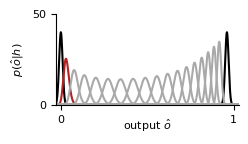

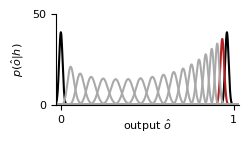

In [134]:
# plot probability distributions p(o|h) for hs_left and hs_right in two plots with reference distributions (integral = sum pmf(x)* \delta x = 1)
for j, hs in enumerate([hs_left, hs_right]):
    fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
    axes = [ax]
    N = params["N"]

    axes[0].plot(support, pmf_ref_left*params["N"], color="black")
    axes[0].plot(support, pmf_ref_right*params["N"], color="black")
    for i, h in enumerate(hs):
        color = "firebrick" if i == 0 else "darkgray"
        axes[0].plot(support, ml_pmf_(h)*params["N"], color=color)
    # set xlabel to the right of the spline
    axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
    axes[0].set_ylabel(r"$p(\hat{o}|h)$")
    axes[0].set_xlim(-3 * params["sigma"], (1 + 3 * params["sigma"]))
    axes[0].set_ylim(ylim_distribution)
    axes[0].set_xticks(xticks_distribution)
    axes[0].set_yticks(yticks_distribution)
    # remove top and right spines
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    plt.show()
    # save as pdf
    if i == 0:
        fig.savefig("./figures/fig_methods_discriminable_left.pdf".format(j), bbox_inches="tight")
    if i == 1:
        fig.savefig("./figures/fig_methods_discriminable_right.pdf".format(j), bbox_inches="tight")

### Gaussian convolution demonstrated for a selection

In [103]:
print(hs_left)
print(len(hs_left), len(hs_right))
#hs_sel = [hs_left[0], hs_left[len(hs_left)//4], hs_left[len(hs_left)//2], hs_right[len(hs_right)//4], hs_right[0]]
hs_sel = [hs_left[0], hs_left[4], hs_left[len(hs_left)//2], hs_right[4], hs_right[0]]
print(hs_sel)

[0.0016922273754612907, 0.004433017801206457, 0.008252857530900123, 0.013202975094114153, 0.019445113658833148, 0.027246028207457758, 0.03698342183041657, 0.04916954814913324, 0.06449644996783327, 0.08391178180729615, 0.10875117395211929, 0.14097644204782014, 0.18364807908171685, 0.24194361509295811, 0.32567676805635737, 0.456758905494422, 0.699306896037294]
17 17
[0.0016922273754612907, 0.019445113658833148, 0.06449644996783327, 0.2168096100455269, 1.002390826638948]


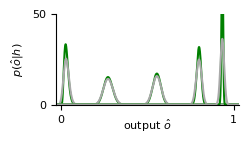

In [117]:
# plot neural network approximation for the selected h values together with the convolution with the normal distribution 
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in hs_sel:
    # network activity
    pmf = ml_pmf(window=win_focus, h=h, lam=lam_focus)
    axes[0].plot(support[1:], pmf*params["N"], color='#008000')

    # Gaussian convolution
    pmf = ml_pmf_noisy(window=win_focus, h=h, lam=lam_focus)
    axes[0].plot(support, pmf*params["N"], color=color)
axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
fig.savefig("./figures/fig_methods_gaussian_convolution.pdf", bbox_inches="tight")

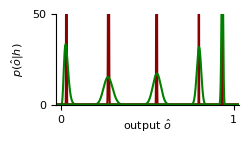

In [135]:
# plot ml_pmf compared to histrogram from simulation
fig, ax = plt.subplots(1, 1, figsize=figsize_distribution)
axes = [ax]
N = params["N"]

for h in hs_sel:
    # window large (1e4)
    pmf = ml_pmf(window=int(1e4), h=h, lam=lam_focus)
    axes[0].plot(support[1:], pmf*params["N"], color='#8B0000')

    # simulation data
    

    # Winwdow focus (1)
    pmf = ml_pmf(window=win_focus, h=h, lam=lam_focus)
    axes[0].plot(support[1:], pmf*params["N"], color='#008000')


axes[0].set_xlabel(r"output $\hat{o}$", labelpad=-5)
axes[0].set_ylabel(r"$p(\hat{o}|h)$")
axes[0].set_xlim(-3*params["sigma"], (1 + 3*params["sigma"]))
axes[0].set_ylim(ylim_distribution)
axes[0].set_xticks(xticks_distribution)
axes[0].set_yticks(yticks_distribution)
# remove top and right spines
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
plt.show()
# save as pdf
#fig.savefig("./figures/fig_methods_examples_simulation.pdf", bbox_inches="tight")

## Case $T\to 0$

In [105]:
# get discriminable inputs (maybe some of this should be outsourced to the theory module?
support_bound = int(params["N"] * (1 + 4 * params["sigma"]))
fp_support = np.arange(-support_bound, support_bound + 1)
fp_pmf_norm = stats.norm.pdf(fp_support, 0, params["N"] * params["sigma"])

def fp_pmf(lam,h):
    return x, pmf_from_coupled_fokker_planck(params, h=h, lam=lam)

def fp_pmf_noise(lam, h):
    x, pmf = fp_pmf(lam, h)
    tmp_pmf = np.zeros_like(fp_support, dtype=np.float64)
    mask = np.where(np.isin(fp_support, x))
    tmp_pmf[mask] = pmf
    # convolution with normal distribution
    return np.convolve(tmp_pmf, fp_pmf_norm, mode="same")

pmf_ = lambda h: fp_pmf_noise(lam_focus, h)

# # determine h range self-consistently from mean-field solution
# a_min = 0.1 * params["sigma"] * params["mu"]
# h_left = -np.log((1 - a_min) / (1 - lam * a_min)) / params["mu"]
# a_max = 1 - 0.1 * params["sigma"]
# h_right = -np.log((1 - a_max) / (1 - lam * a_max))
# h_range = (h_left, h_right)

# # reference distributions
# ref_left = stats.norm.pdf(
#     fp_support,
#     params["N"] * mean_field_activity(lam, params["mu"], h=0),
#     params["N"] * params["sigma"],
# )
# ref_right = stats.norm.pdf(
#     fp_support,
#     params["N"] * mean_field_activity(lam, params["mu"], h=np.inf),
#     params["N"] * params["sigma"],
# )
# pmf_refs = [ref_left, ref_right]

# hs_left = find_discriminable_inputs(
#     pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="left"
# )
# hs_right = find_discriminable_inputs(
#     pmf_o_given_h, h_range, pmf_refs, params["epsilon"], start="right"
# )

In [ ]:
# plot analytic solution compared to simulations with T=1
